In [ ]:
using Pkg
cd("../")
Pkg.activate(".")
using PyPlot
using Distributions

In [2]:
function naive_likelihood_calc(n,N,p)
    return (p^n) * ((1-p)^(N-n))
end

function likelihood_calc(n,N,p)
    if N >= 67
        l = NaN
    else
        l = binomial(N,n) * naive_likelihood_calc(n,N,p)
    end
    return l
end

likelihood_calc (generic function with 1 method)

In [3]:
function exact_pval_calc(n,N)
    p=0.5
    pval = 0
    for m = n:N
        pval = pval + likelihood_calc(m,N,p)
    end
    return pval
end

exact_pval_calc (generic function with 1 method)

In [4]:
function approx_pval_calc(n,N)
    p=0.5
    μ = N*p
    σ = sqrt(N*p*(1-p))
    pval = 1 - cdf(Normal(μ,σ), n)
    return pval
end

approx_pval_calc (generic function with 1 method)

In [5]:
function exact_logBF_calc(n,N;g1=ones(100))
    dp = 1/length(g1)
    ps = (1:length(g1))./(length(g1)) .- (dp/2)
    int_g = sum(naive_likelihood_calc.(n,N,ps) .* g1) * dp
    logBF = log(int_g) + N*log(2)
    return logBF
end

exact_logBF_calc (generic function with 1 method)

In [6]:
function approx_logBF_calc(n,N)
    if 2*n < N
        logBF = - log(N)/2
    else
        logBF = n * log(n/N) + (N-n) * log((N-n)/N) - log(N)/2 + N*log(2)
    end
    return logBF
end

approx_logBF_calc (generic function with 1 method)

In [7]:
N_max = 60
log_Pvals_exact = zeros(N_max+1,N_max)
log_Pvals_appro = zeros(N_max+1,N_max)
log_BF_exact = zeros(N_max+1,N_max)
log_BF_appro = zeros(N_max+1,N_max)

g1 = ones(10000)*2
g1[1:5000] .= 0;

In [8]:
for N = 1:N_max
    for n = 0:N
        log_Pvals_exact[n+1,N] = log(exact_pval_calc(n,N))
        log_Pvals_appro[n+1,N] = log(approx_pval_calc(n,N))
        
        log_BF_exact[n+1,N] = exact_logBF_calc(n,N;g1=g1)
        log_BF_appro[n+1,N] = approx_logBF_calc(n,N)
    end
    if N<N_max
        log_Pvals_exact[(N+1):end,N] .= NaN
        log_Pvals_appro[(N+1):end,N] .= NaN
        log_BF_exact[(N+1):end,N] .= NaN
        log_BF_appro[(N+1):end,N] .= NaN
    end
end

log_Pvals_appro[isinf.(log_Pvals_appro)] .= -100;

In [9]:
exact_pval_sign_level = (log_Pvals_exact .< log(0.1)) .+ (log_Pvals_exact .< log(0.05)) .+
                        (log_Pvals_exact .< log(0.01)) .+ (log_Pvals_exact .< log(0.001))

appro_pval_sign_level = (log_Pvals_appro .< log(0.1)) .+ (log_Pvals_appro .< log(0.05)) .+
                        (log_Pvals_appro .< log(0.01)) .+ (log_Pvals_appro .< log(0.001))

exact_BF_sign_level = (log_BF_exact .> log(1))  .+  (log_BF_exact .> log(3)) .+
                      (log_BF_exact .> log(20)) .+ (log_BF_exact .> log(150))

appro_BF_sign_level = (log_BF_appro .> log(1))  .+ (log_BF_appro .> log(3)) .+
                      (log_BF_appro .> log(20)) .+ (log_BF_appro .> log(150));


exact_pval_sign_level = 1. .* exact_pval_sign_level
appro_pval_sign_level = 1. .* appro_pval_sign_level
exact_BF_sign_level = 1. .* exact_BF_sign_level
appro_BF_sign_level = 1. .* appro_BF_sign_level

exact_pval_sign_level[isnan.(log_Pvals_exact)] .= NaN
appro_pval_sign_level[isnan.(log_Pvals_appro)] .= NaN
exact_BF_sign_level[isnan.(log_BF_exact)] .= NaN
appro_BF_sign_level[isnan.(log_BF_appro)] .= NaN;

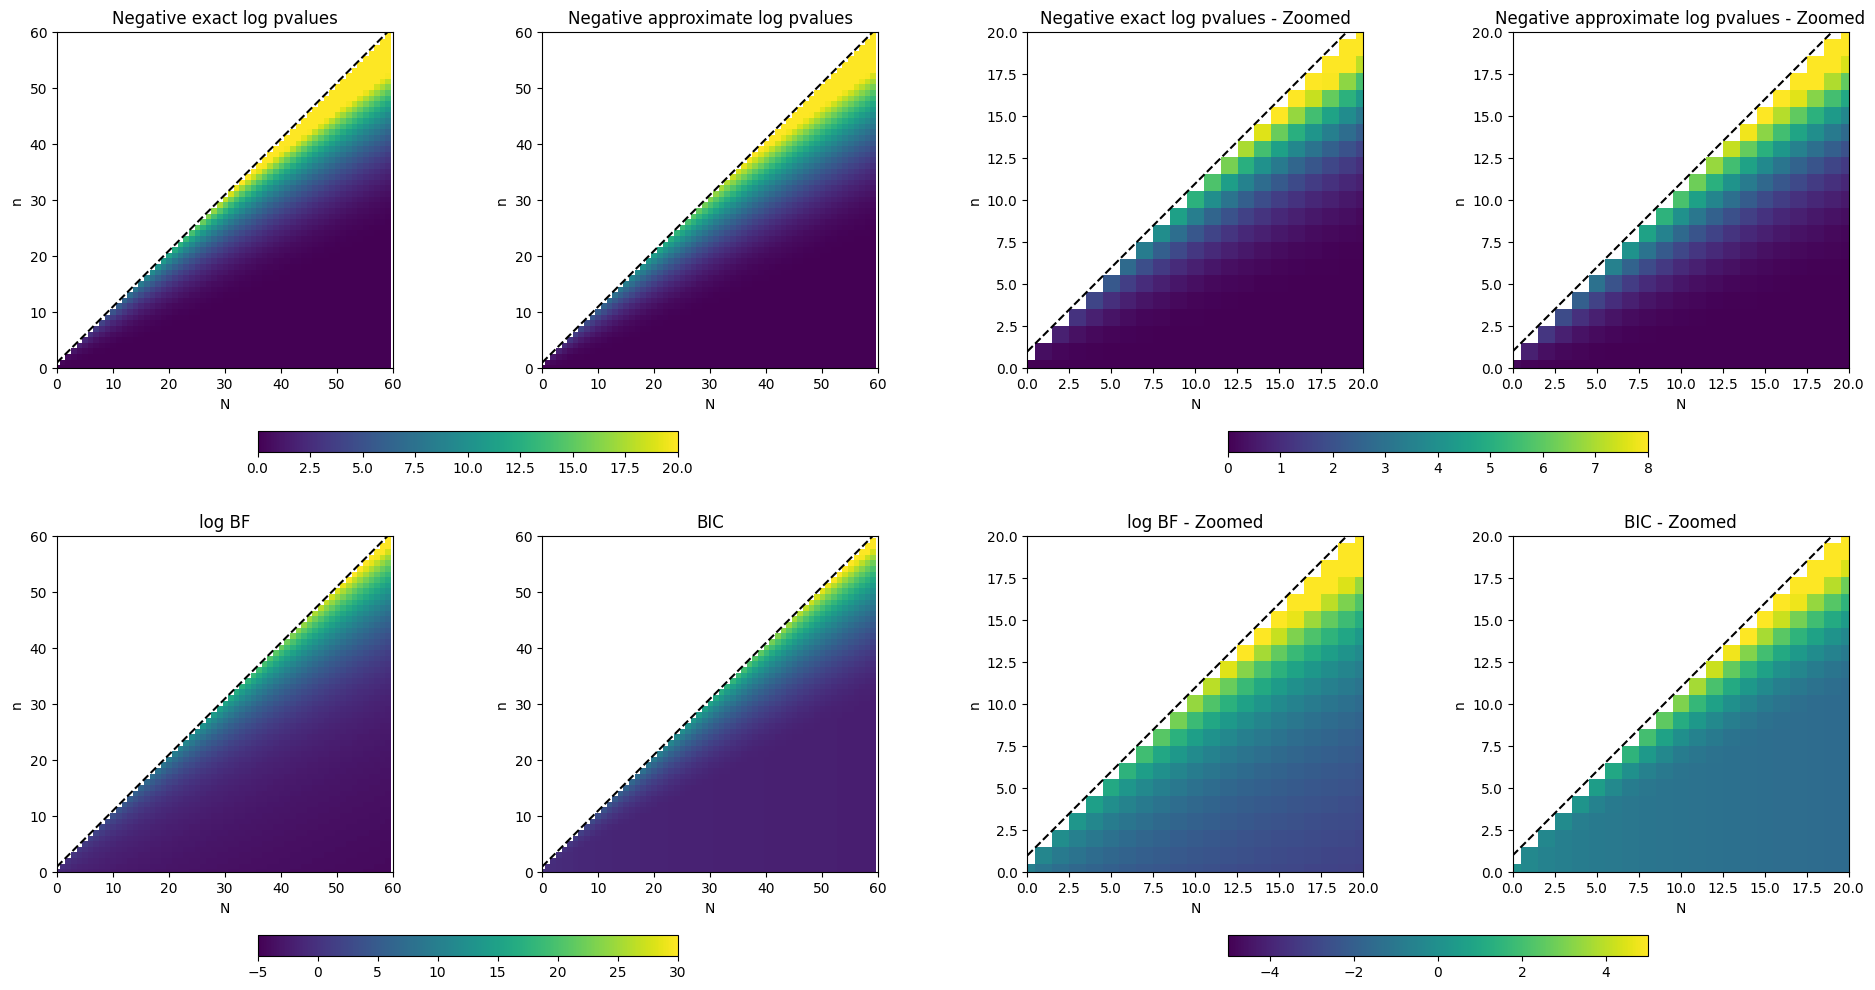

PyObject <matplotlib.colorbar.Colorbar object at 0x7f94b07a3550>

In [10]:
N_max2 = 20
fig, ax = subplots(2, 4, figsize=(24, 12))

vmin = 0
vmax = 20
heatmap1 = ax[1,1].imshow(-log_Pvals_exact,vmin=vmin,vmax=vmax)
ax[1,1].set_xlabel("N")
ax[1,1].set_ylabel("n")
ax[1,1].set_title("Negative exact log pvalues")
ax[1,1].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[1,1].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[1,1].set_ylim(0,N_max)
ax[1,1].set_xlim(0,N_max)

ax[1,2].imshow(-log_Pvals_appro,vmin=vmin,vmax=vmax)
ax[1,2].set_xlabel("N")
ax[1,2].set_ylabel("n")
ax[1,2].set_title("Negative approximate log pvalues")
ax[1,2].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[1,2].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[1,2].set_ylim(0,N_max)
ax[1,2].set_xlim(0,N_max)

fig.colorbar(heatmap1,ax=ax[1,1:2],orientation="horizontal", fraction=0.05)

vmin = 0
vmax = 8
heatmap2 = ax[1,3].imshow(-log_Pvals_exact,vmin=vmin,vmax=vmax)
ax[1,3].set_xlabel("N")
ax[1,3].set_ylabel("n")
ax[1,3].set_title("Negative exact log pvalues - Zoomed")
ax[1,3].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[1,3].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[1,3].set_ylim(0,N_max2)
ax[1,3].set_xlim(0,N_max2)

ax[1,4].imshow(-log_Pvals_appro,vmin=vmin,vmax=vmax)
ax[1,4].set_xlabel("N")
ax[1,4].set_ylabel("n")
ax[1,4].set_title("Negative approximate log pvalues - Zoomed")
ax[1,4].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[1,4].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[1,4].set_ylim(0,N_max2)
ax[1,4].set_xlim(0,N_max2)

fig.colorbar(heatmap2,ax=ax[1,3:4],orientation="horizontal", fraction=0.05)

vmin = -5
vmax = 30
heatmap3 = ax[2,1].imshow(log_BF_exact,vmin=vmin,vmax=vmax)
ax[2,1].set_xlabel("N")
ax[2,1].set_ylabel("n")
ax[2,1].set_title("log BF")
ax[2,1].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[2,1].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[2,1].set_ylim(0,N_max)
ax[2,1].set_xlim(0,N_max)

ax[2,2].imshow(log_BF_appro,vmin=vmin,vmax=vmax)
ax[2,2].set_xlabel("N")
ax[2,2].set_ylabel("n")
ax[2,2].set_title("BIC")
ax[2,2].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[2,2].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[2,2].set_ylim(0,N_max)
ax[2,2].set_xlim(0,N_max)

fig.colorbar(heatmap3,ax=ax[2,1:2],orientation="horizontal", fraction=0.05)

vmin = -5
vmax = 5
heatmap4 = ax[2,3].imshow(log_BF_exact,vmin=vmin,vmax=vmax)
ax[2,3].set_xlabel("N")
ax[2,3].set_ylabel("n")
ax[2,3].set_title("log BF - Zoomed")
ax[2,3].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[2,3].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[2,3].set_ylim(0,N_max2)
ax[2,3].set_xlim(0,N_max2)

ax[2,4].imshow(log_BF_appro,vmin=vmin,vmax=vmax)
ax[2,4].set_xlabel("N")
ax[2,4].set_ylabel("n")
ax[2,4].set_title("BIC - Zoomed")
ax[2,4].plot(0:N_max,(1:(N_max+1)),"--k")
#ax[2,4].plot(0:N_max,(1:(N_max+1))./2,"--w")
ax[2,4].set_ylim(0,N_max2)
ax[2,4].set_xlim(0,N_max2)

fig.colorbar(heatmap4,ax=ax[2,3:4],orientation="horizontal", fraction=0.05)

In [11]:
function find_sign_ratio(X,thr)
    n = length(X)
    ind = 1:n
    ind_sign = ind[X .>= thr]
    if length(ind_sign)>0
        ratio = findmin(ind_sign)[1]/n
    else
        ratio = NaN
    end
    return ratio
end

find_sign_ratio (generic function with 1 method)

In [12]:
exact_pval_sign_level_ratio = zeros(4,N_max)
appro_pval_sign_level_ratio = zeros(4,N_max)
exact_BF_sign_level_ratio = zeros(4,N_max)
appro_BF_sign_level_ratio = zeros(4,N_max)

for n =1:N_max
    exact_pval_sign_level_ratio[1,n] = find_sign_ratio(exact_pval_sign_level[1:n,n],1)
    exact_pval_sign_level_ratio[2,n] = find_sign_ratio(exact_pval_sign_level[1:n,n],2)
    exact_pval_sign_level_ratio[3,n] = find_sign_ratio(exact_pval_sign_level[1:n,n],3)
    exact_pval_sign_level_ratio[4,n] = find_sign_ratio(exact_pval_sign_level[1:n,n],4)
    
    appro_pval_sign_level_ratio[1,n] = find_sign_ratio(appro_pval_sign_level[1:n,n],1)
    appro_pval_sign_level_ratio[2,n] = find_sign_ratio(appro_pval_sign_level[1:n,n],2)
    appro_pval_sign_level_ratio[3,n] = find_sign_ratio(appro_pval_sign_level[1:n,n],3)
    appro_pval_sign_level_ratio[4,n] = find_sign_ratio(appro_pval_sign_level[1:n,n],4)
    
    exact_BF_sign_level_ratio[1,n] = find_sign_ratio(exact_BF_sign_level[1:n,n],1)
    exact_BF_sign_level_ratio[2,n] = find_sign_ratio(exact_BF_sign_level[1:n,n],2)
    exact_BF_sign_level_ratio[3,n] = find_sign_ratio(exact_BF_sign_level[1:n,n],3)
    exact_BF_sign_level_ratio[4,n] = find_sign_ratio(exact_BF_sign_level[1:n,n],4)
    
    appro_BF_sign_level_ratio[1,n] = find_sign_ratio(appro_BF_sign_level[1:n,n],1)
    appro_BF_sign_level_ratio[2,n] = find_sign_ratio(appro_BF_sign_level[1:n,n],2)
    appro_BF_sign_level_ratio[3,n] = find_sign_ratio(appro_BF_sign_level[1:n,n],3)
    appro_BF_sign_level_ratio[4,n] = find_sign_ratio(appro_BF_sign_level[1:n,n],4)
end


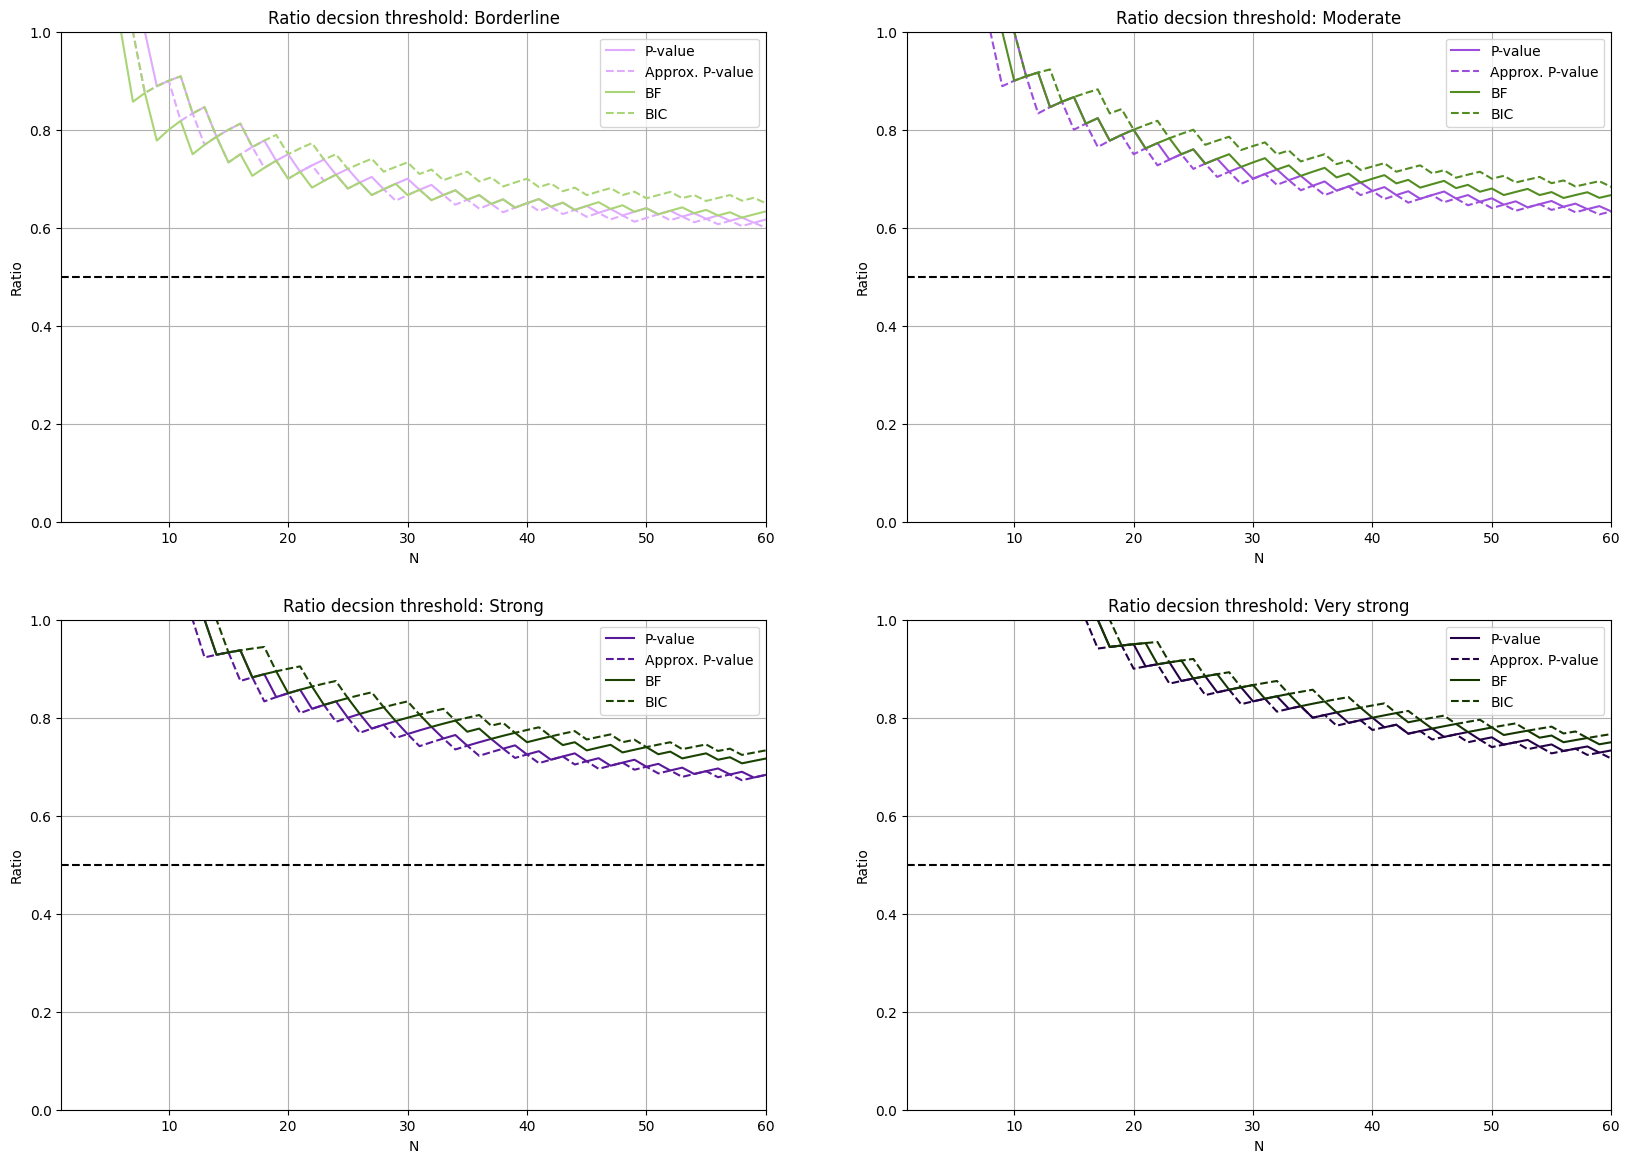

(1.0, 60.0)

In [13]:
fig, ax = subplots(2, 2, figsize=(20, 14))
ax[1].plot(1:N_max,exact_pval_sign_level_ratio[1,:],color="#e0aaff")
ax[1].plot(1:N_max,appro_pval_sign_level_ratio[1,:],color="#e0aaff",ls="--")
ax[1].plot(1:N_max,exact_BF_sign_level_ratio[1,:],color="#aad576")
ax[1].plot(1:N_max,appro_BF_sign_level_ratio[1,:],color="#aad576",ls="--")
ax[1].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[1].grid()
ax[1].set_title("Ratio decsion threshold: Borderline")
ax[1].legend(["P-value","Approx. P-value", "BF", "BIC"])
ax[1].set_xlabel("N")
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0,1)
ax[1].set_xlim(1,N_max)

ax[3].plot(1:N_max,exact_pval_sign_level_ratio[2,:],color="#9d4edd")
ax[3].plot(1:N_max,appro_pval_sign_level_ratio[2,:],color="#9d4edd",ls="--")
ax[3].plot(1:N_max,exact_BF_sign_level_ratio[2,:],color="#538d22")
ax[3].plot(1:N_max,appro_BF_sign_level_ratio[2,:],color="#538d22",ls="--")
ax[3].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[3].grid()
ax[3].set_title("Ratio decsion threshold: Moderate")
ax[3].legend(["P-value","Approx. P-value", "BF", "BIC"])
ax[3].set_xlabel("N")
ax[3].set_ylabel("Ratio")
ax[3].set_ylim(0,1)
ax[3].set_xlim(1,N_max)

ax[2].plot(1:N_max,exact_pval_sign_level_ratio[3,:],color="#5a189a")
ax[2].plot(1:N_max,appro_pval_sign_level_ratio[3,:],color="#5a189a",ls="--")
ax[2].plot(1:N_max,exact_BF_sign_level_ratio[3,:],color="#1a4301")
ax[2].plot(1:N_max,appro_BF_sign_level_ratio[3,:],color="#1a4301",ls="--")
ax[2].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[2].grid()
ax[2].set_title("Ratio decsion threshold: Strong")
ax[2].legend(["P-value","Approx. P-value", "BF", "BIC"])
ax[2].set_xlabel("N")
ax[2].set_ylabel("Ratio")
ax[2].set_ylim(0,1)
ax[2].set_xlim(1,N_max)

ax[4].plot(1:N_max,exact_pval_sign_level_ratio[4,:],color="#240046")
ax[4].plot(1:N_max,appro_pval_sign_level_ratio[4,:],color="#240046",ls="--")
ax[4].plot(1:N_max,exact_BF_sign_level_ratio[4,:],color="#143601")
ax[4].plot(1:N_max,appro_BF_sign_level_ratio[4,:],color="#143601",ls="--")
ax[4].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[4].grid()
ax[4].set_title("Ratio decsion threshold: Very strong")
ax[4].legend(["P-value","Approx. P-value", "BF", "BIC"])
ax[4].set_xlabel("N")
ax[4].set_ylabel("Ratio")
ax[4].set_ylim(0,1)
ax[4].set_xlim(1,N_max)

In [14]:
function find_sign_ratio_max(X,thr)
    n = length(X)
    ind = 1:n
    ind_sign = ind[X .>= thr]
    if length(ind_sign)>0
        ratio = findmax(ind_sign)[1]/n
    else
        ratio = NaN
    end
    return ratio
end

find_sign_ratio_max (generic function with 1 method)

In [15]:
exact_BF_neg_sign_level = (log_BF_exact .< -log(1))  .+  (log_BF_exact .< -log(3)) .+
                          (log_BF_exact .< -log(20)) .+ (log_BF_exact .< -log(150))

appro_BF_neg_sign_level = (log_BF_appro .< -log(1))  .+ (log_BF_appro .< -log(3)) .+
                          (log_BF_appro .< -log(20)) .+ (log_BF_appro .< -log(150));


exact_BF_neg_sign_level = 1. .* exact_BF_neg_sign_level
appro_BF_neg_sign_level = 1. .* appro_BF_neg_sign_level

exact_BF_neg_sign_level[isnan.(log_BF_exact)] .= NaN
appro_BF_neg_sign_level[isnan.(log_BF_appro)] .= NaN;

In [16]:
exact_BF_neg_sign_level_ratio = zeros(4,N_max)
appro_BF_neg_sign_level_ratio = zeros(4,N_max)

for n =1:N_max
    exact_BF_neg_sign_level_ratio[1,n] = find_sign_ratio_max(exact_BF_neg_sign_level[1:n,n],1)
    exact_BF_neg_sign_level_ratio[2,n] = find_sign_ratio_max(exact_BF_neg_sign_level[1:n,n],2)
    exact_BF_neg_sign_level_ratio[3,n] = find_sign_ratio_max(exact_BF_neg_sign_level[1:n,n],3)
    exact_BF_neg_sign_level_ratio[4,n] = find_sign_ratio_max(exact_BF_neg_sign_level[1:n,n],4)
    
    appro_BF_neg_sign_level_ratio[1,n] = find_sign_ratio_max(appro_BF_neg_sign_level[1:n,n],1)
    appro_BF_neg_sign_level_ratio[2,n] = find_sign_ratio_max(appro_BF_neg_sign_level[1:n,n],2)
    appro_BF_neg_sign_level_ratio[3,n] = find_sign_ratio_max(appro_BF_neg_sign_level[1:n,n],3)
    appro_BF_neg_sign_level_ratio[4,n] = find_sign_ratio_max(appro_BF_neg_sign_level[1:n,n],4)
end


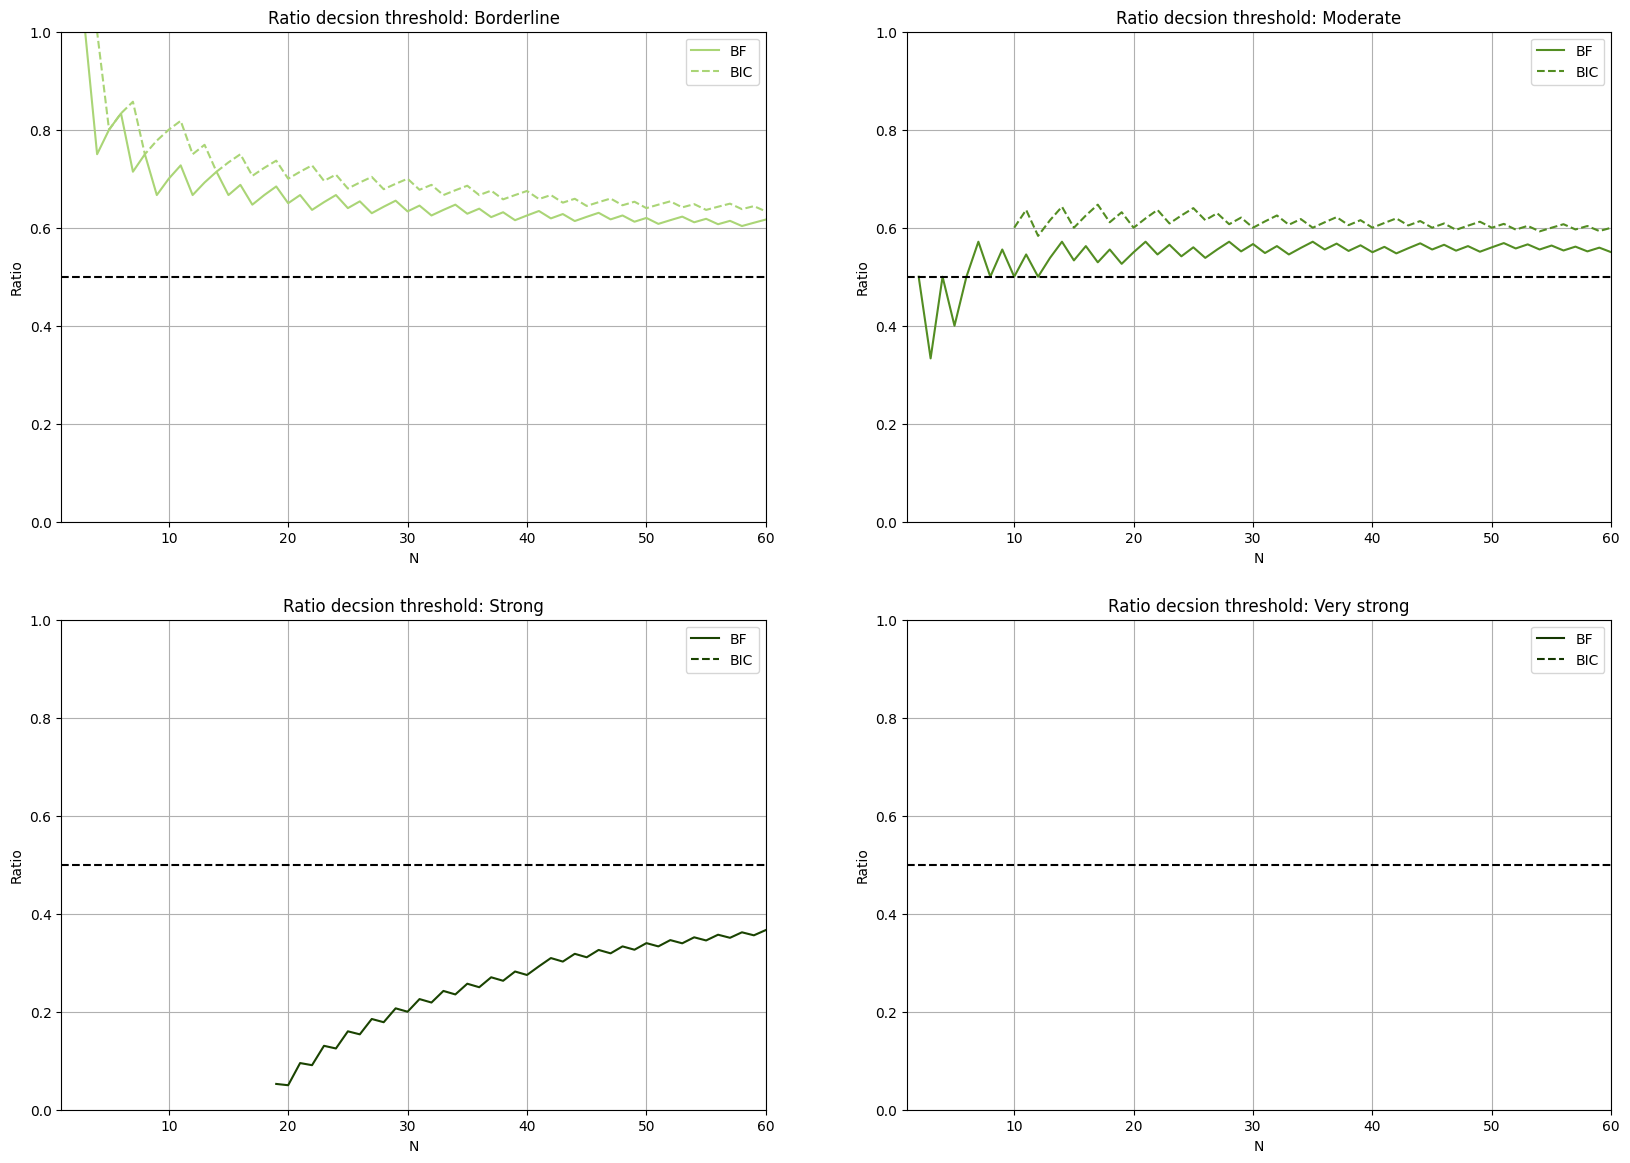

(1.0, 60.0)

In [17]:
fig, ax = subplots(2, 2, figsize=(20, 14))
ax[1].plot(1:N_max,exact_BF_neg_sign_level_ratio[1,:],color="#aad576")
ax[1].plot(1:N_max,appro_BF_neg_sign_level_ratio[1,:],color="#aad576",ls="--")
ax[1].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[1].grid()
ax[1].set_title("Ratio decsion threshold: Borderline")
ax[1].legend(["BF", "BIC"])
ax[1].set_xlabel("N")
ax[1].set_ylabel("Ratio")
ax[1].set_ylim(0,1)
ax[1].set_xlim(1,N_max)

ax[3].plot(1:N_max,exact_BF_neg_sign_level_ratio[2,:],color="#538d22")
ax[3].plot(1:N_max,appro_BF_neg_sign_level_ratio[2,:],color="#538d22",ls="--")
ax[3].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[3].grid()
ax[3].set_title("Ratio decsion threshold: Moderate")
ax[3].legend(["BF", "BIC"])
ax[3].set_xlabel("N")
ax[3].set_ylabel("Ratio")
ax[3].set_ylim(0,1)
ax[3].set_xlim(1,N_max)

ax[2].plot(1:N_max,exact_BF_neg_sign_level_ratio[3,:],color="#1a4301")
ax[2].plot(1:N_max,appro_BF_neg_sign_level_ratio[3,:],color="#1a4301",ls="--")
ax[2].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[2].grid()
ax[2].set_title("Ratio decsion threshold: Strong")
ax[2].legend(["BF", "BIC"])
ax[2].set_xlabel("N")
ax[2].set_ylabel("Ratio")
ax[2].set_ylim(0,1)
ax[2].set_xlim(1,N_max)

ax[4].plot(1:N_max,exact_BF_neg_sign_level_ratio[4,:],color="#143601")
ax[4].plot(1:N_max,appro_BF_neg_sign_level_ratio[4,:],color="#143601",ls="--")
ax[4].plot(1:N_max,ones(N_max)*0.5,"--k")
ax[4].grid()
ax[4].set_title("Ratio decsion threshold: Very strong")
ax[4].legend(["BF", "BIC"])
ax[4].set_xlabel("N")
ax[4].set_ylabel("Ratio")
ax[4].set_ylim(0,1)
ax[4].set_xlim(1,N_max)